In [1]:
from data.data import fetch_data, preprocess_data
from backtesting.backtest import MyStrategy, run_backtest
from visualization.visualize import plot_equity_curve
from analysis.analysis import calculate_annualized_return, calculate_volatility, calculate_sharpe_ratio, calculate_sortino_ratio, calculate_max_drawdown, calculate_information_ratio, calculate_alpha_beta
import pandas as pd
import matplotlib.pyplot as plt
import backtrader as bt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


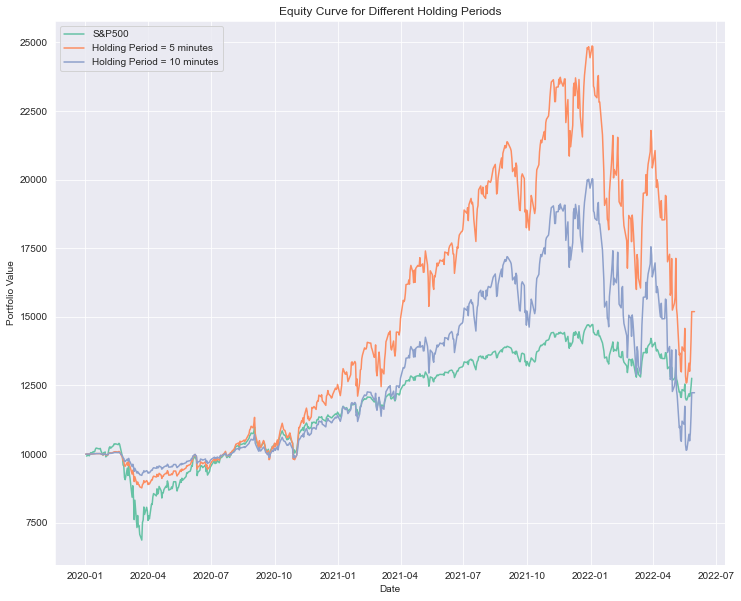

In [18]:
# Fetch and preprocess data
sandp500_data = fetch_data('ES=F', '2020-01-01', '2022-05-31')
etf_long_data = fetch_data('SPXL', '2020-01-01', '2022-05-31')  # Replace with your long ETF ticker
etf_short_data = fetch_data('SPXS', '2020-01-01', '2022-05-31')  # Replace with your short ETF ticker
benchmark_data = fetch_data('^GSPC', '2020-01-01', '2022-05-31')
# Fetch and preprocess benchmark data (example: S&P 500)
benchmark_data = preprocess_data(benchmark_data)

# Calculate daily returns of benchmark
benchmark_returns = benchmark_data['Close'].pct_change().dropna()

sandp500_data = preprocess_data(sandp500_data)
etf_long_data = preprocess_data(etf_long_data)
etf_short_data = preprocess_data(etf_short_data)
hold_periods = [1, 2]  # Holding periods to test each 5 minutes is 1 unit here

plt.figure(figsize=(12, 10))

# Calculate the cumulative returns of the benchmark and plot it
benchmark_cumulative_returns = (benchmark_returns + 1).cumprod()
benchmark_portfolio_value = benchmark_cumulative_returns * 10000  # Scale to initial investment
plt.plot(benchmark_portfolio_value, label='S&P500')

for hold_period in hold_periods:
    results = run_backtest(MyStrategy, sandp500_data, etf_long_data, etf_short_data, hold_period=hold_period)
    strategy = results[0]
    portfolio_values = pd.Series(strategy.portfolio_values, index=strategy.timestamps)
    plt.plot(portfolio_values, label=f'Holding Period = {hold_period*5} minutes')

plt.title('Equity Curve for Different Holding Periods')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
for hold_period in hold_periods:
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(MyStrategy, hold_period=hold_period)

    # Create data feeds
    data0 = bt.feeds.PandasData(dataname=sandp500_data)
    data1 = bt.feeds.PandasData(dataname=etf_long_data)
    data2 = bt.feeds.PandasData(dataname=etf_short_data)

    # Add the Data Feeds to Cerebro
    cerebro.adddata(data0)
    cerebro.adddata(data1)
    cerebro.adddata(data2)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Run the strategy
    print('\nStarting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    thestrats = cerebro.run()
    thestrat = thestrats[0]  # the strategy
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print(f'For holding period = {hold_period/12} hours: SPXL buys = {thestrat.etf_long_buys}, SPXS buys = {thestrat.etf_short_buys}')


Starting Portfolio Value: 100000.00
Final Portfolio Value: 100957.04
For holding period = 0.08333333333333333 hours: SPXL buys = 355, SPXS buys = 0

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100816.15
For holding period = 0.16666666666666666 hours: SPXL buys = 182, SPXS buys = 0


In [20]:
returns_dict = {}
values_dict = {}

for hold_period in hold_periods:
    results = run_backtest(MyStrategy, sandp500_data, etf_long_data, etf_short_data, hold_period=hold_period)
    strategy = results[0]
    portfolio_values = pd.Series(strategy.portfolio_values, index=strategy.timestamps)
    daily_returns = portfolio_values.pct_change().dropna()  # Calculate daily returns
    returns_dict[hold_period] = daily_returns
    values_dict[hold_period] = portfolio_values

metrics_df = pd.DataFrame(columns=['Hours', 'Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Alpha', 'Beta', 'Information Ratio'])

for hold_period in hold_periods:
    daily_returns = returns_dict[hold_period]
    portfolio_values = values_dict[hold_period]

    # Align daily_returns with benchmark_returns
    daily_returns = daily_returns.reindex(benchmark_returns.index, method='pad')

    total_return = portfolio_values[-1] / portfolio_values[0] - 1
    annualized_return = calculate_annualized_return(daily_returns)
    volatility = calculate_volatility(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(portfolio_values)
    alpha, beta = calculate_alpha_beta(daily_returns, benchmark_returns)
    information_ratio = calculate_information_ratio(daily_returns, benchmark_returns)

    # Convert hold_period to hours
    hours = hold_period / 12

    metrics_df.loc[hold_period] = [hours, total_return, annualized_return, volatility, sharpe_ratio, sortino_ratio, max_drawdown, alpha, beta, information_ratio]

In [21]:
metrics_df

,Hours,Total Return,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Alpha,Beta,Information Ratio
1,0.083333,0.519029,0.257346,0.406428,0.039854,0.717941,0.0,0.000441,1.082616,0.026018
2,0.166667,0.223568,0.153158,0.370037,0.026052,0.414943,0.0,0.000128,0.896616,0.003951
